# Compare the recall word vectors to the story vectors 
# Output 16 X 16 matrix 
# 12/14/20
# 1/7/21 - adding the 4 x 16 visualization

In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize

from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

%autosave 5

Autosaving every 5 seconds


# 0. Importing story and template vectors and sums 

In [2]:
templates = pickle.load( open( 'c_template', "rb" ) )
recalls = pickle.load( open( 'c_recall', "rb" ) )
stories = pickle.load( open( 'c_stories', "rb" ) )
# sums
sums = pickle.load( open( "new_sums", "rb" ) )

# I. Avg correlation between word vectors of recall and template word vectors 
### (not avg the recall vectors, avging the correlations)
## A. story template x story vector

In [3]:
story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]
template_order = [1,2,3,4,10,20,30,40]
correls = np.zeros((16,16))
count = 0

for key in story_order:
    n = sums[key][0]
    all_partcs = np.zeros((16, n))
    count_inner = 0
    # Loop through all conditions
    for i in range(0, 3):
        n_partc = recalls[key][i].shape[0]
        for j in range(0, n_partc):
            this_vec = recalls[key][i][j]
            this_partc = np.zeros((16,1))
            count_ii = 0
            for story_key in story_order:
                this_coef = np.corrcoef(this_vec, stories[story_key])
                this_partc[count_ii] = this_coef[0,1]
                count_ii += 1
            this_partc = np.ravel(this_partc)
            all_partcs[:, count_inner] = this_partc
            count_inner += 1
    # Avg all_partcs
    this_avg = np.mean(all_partcs, axis = 1)
    correls[:, count] = this_avg
    count += 1

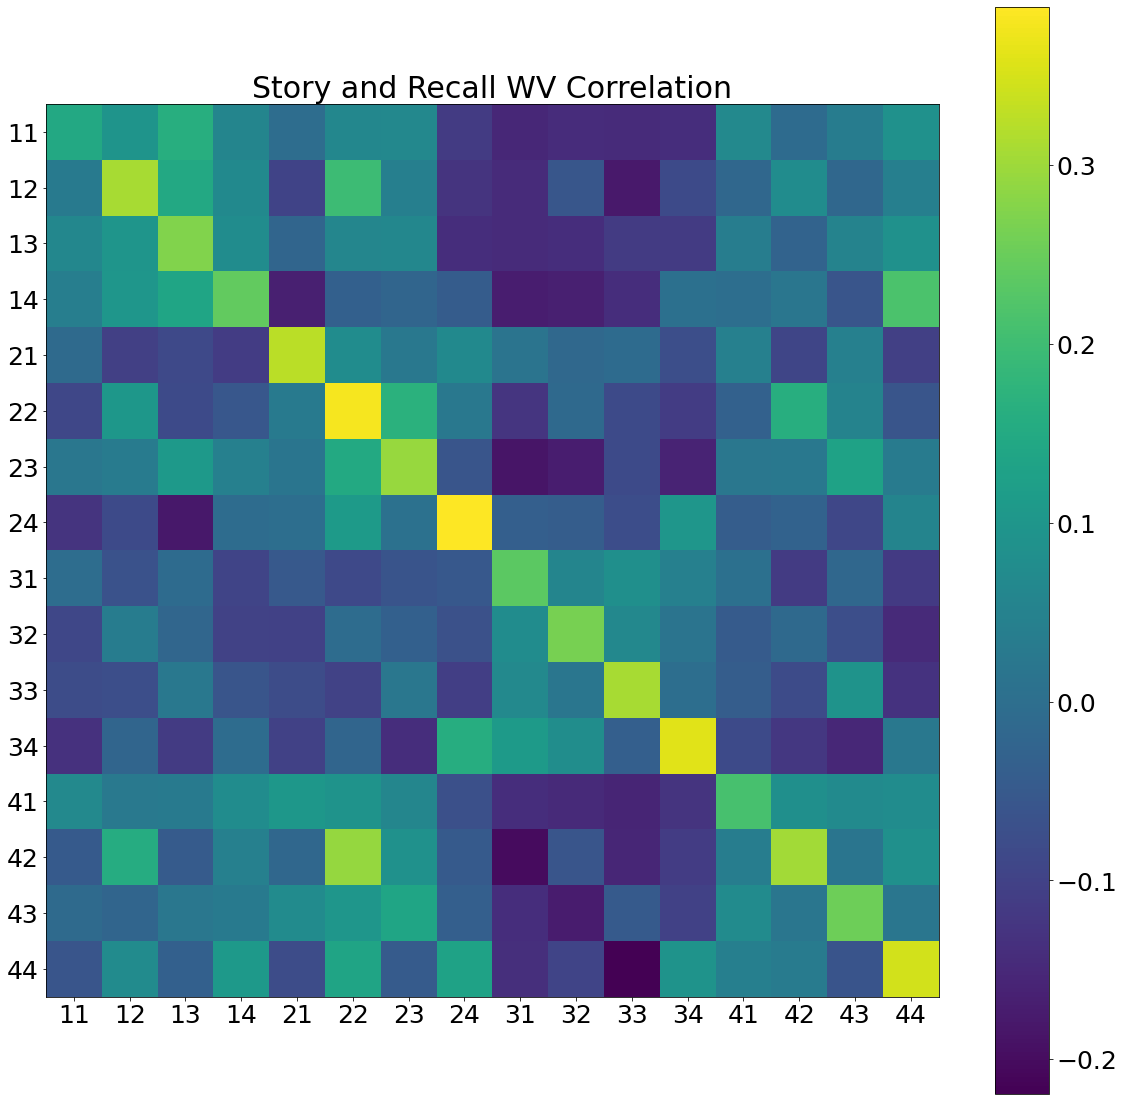

In [7]:
y_label = ['11', '12', '13','14', '21', '22', '23', '24', '31','32', '33', '34', '41', '42', '43', '44']

plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(1,1, figsize=(20,20))
im = ax.imshow(correls)

fig.colorbar(im)

# X ticks
ax.set_xticks(np.arange(0,16))
ax.set_xticklabels(story_order)

# Y ticks
ax.set_yticks(np.arange(0,16))
ax.set_yticklabels(y_label)

plt.title('Story and Recall WV Correlation')

plt.savefig('recallsstories.png')

## C. Normalize each row

[Text(0, 0, '11:restaurant- breakup'),
 Text(0, 0, '12:airport - breakup'),
 Text(0, 0, '13:grocery store - breakup'),
 Text(0, 0, '14: lecture hall - breakup'),
 Text(0, 0, '21:restaurant - proposal'),
 Text(0, 0, '22: airport - proposal'),
 Text(0, 0, '23: grocery store - proposal'),
 Text(0, 0, '24: lecture hall - proposal'),
 Text(0, 0, '31:restaurant - business deal'),
 Text(0, 0, '32: airport - business deal'),
 Text(0, 0, '33: grocery store - business deal'),
 Text(0, 0, '34: lecture hall - business deal'),
 Text(0, 0, '41:restaurant - meet cute'),
 Text(0, 0, '42: airport - meet cute'),
 Text(0, 0, '43: grocery store - meet cute'),
 Text(0, 0, '44: lecture hall - meet cute')]

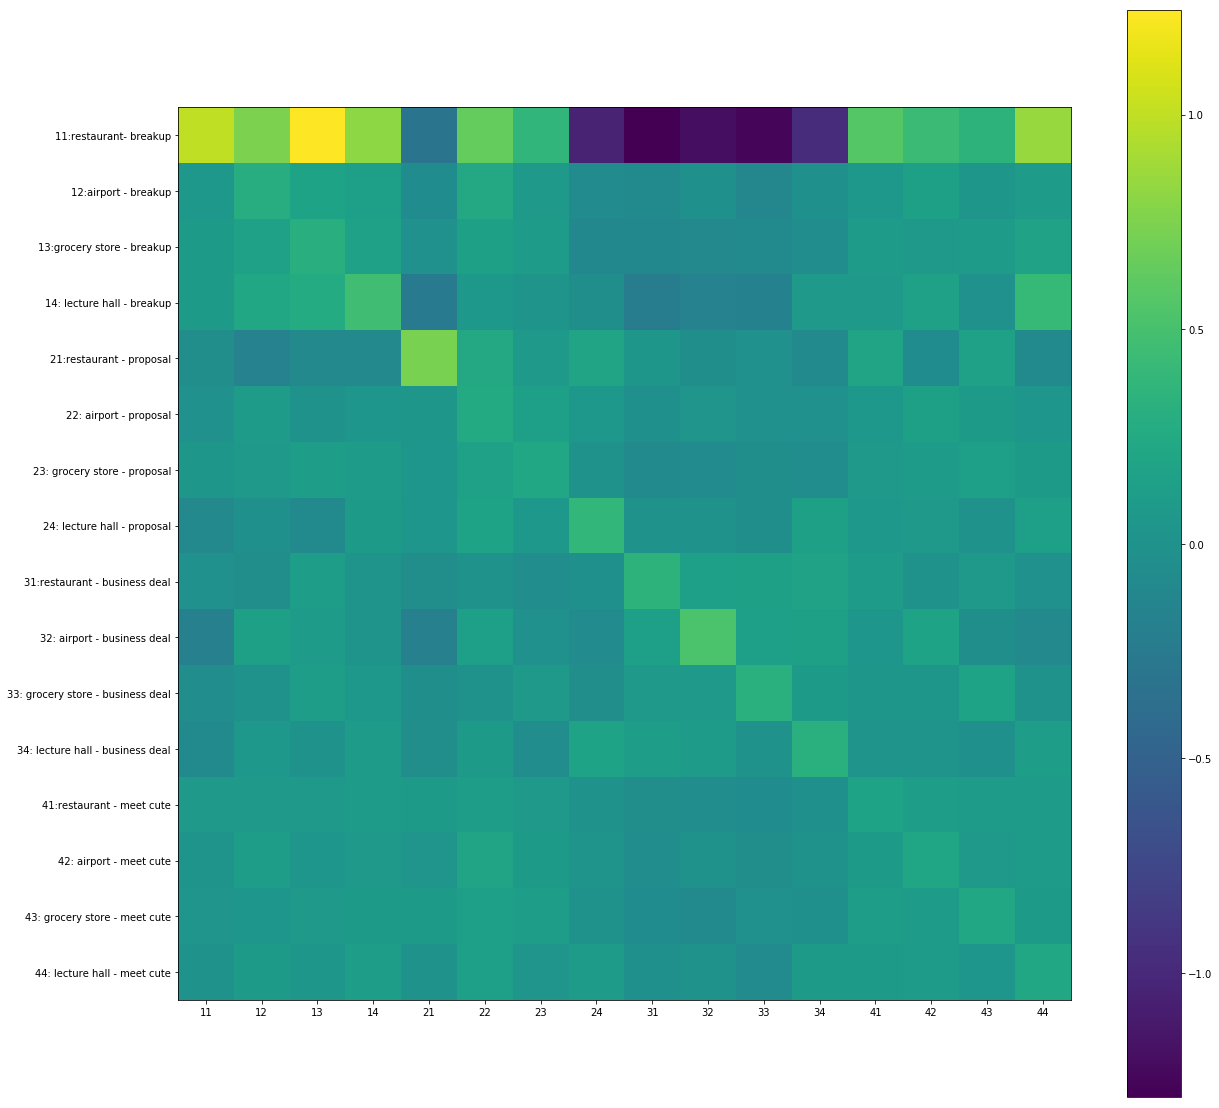

In [5]:
sum_of_rows = correls.sum(axis=1)
normalized_array = correls / sum_of_rows[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(20,20))
im = ax.imshow(normalized_array)

fig.colorbar(im)

# X ticks
ax.set_xticks(np.arange(0,16))
ax.set_xticklabels(story_order)

# Y ticks
ax.set_yticks(np.arange(0,16))
ax.set_yticklabels(y_label)



## C. Normalize each column (not row)

[Text(0, 0, '11:restaurant- breakup'),
 Text(0, 0, '12:airport - breakup'),
 Text(0, 0, '13:grocery store - breakup'),
 Text(0, 0, '14: lecture hall - breakup'),
 Text(0, 0, '21:restaurant - proposal'),
 Text(0, 0, '22: airport - proposal'),
 Text(0, 0, '23: grocery store - proposal'),
 Text(0, 0, '24: lecture hall - proposal'),
 Text(0, 0, '31:restaurant - business deal'),
 Text(0, 0, '32: airport - business deal'),
 Text(0, 0, '33: grocery store - business deal'),
 Text(0, 0, '34: lecture hall - business deal'),
 Text(0, 0, '41:restaurant - meet cute'),
 Text(0, 0, '42: airport - meet cute'),
 Text(0, 0, '43: grocery store - meet cute'),
 Text(0, 0, '44: lecture hall - meet cute')]

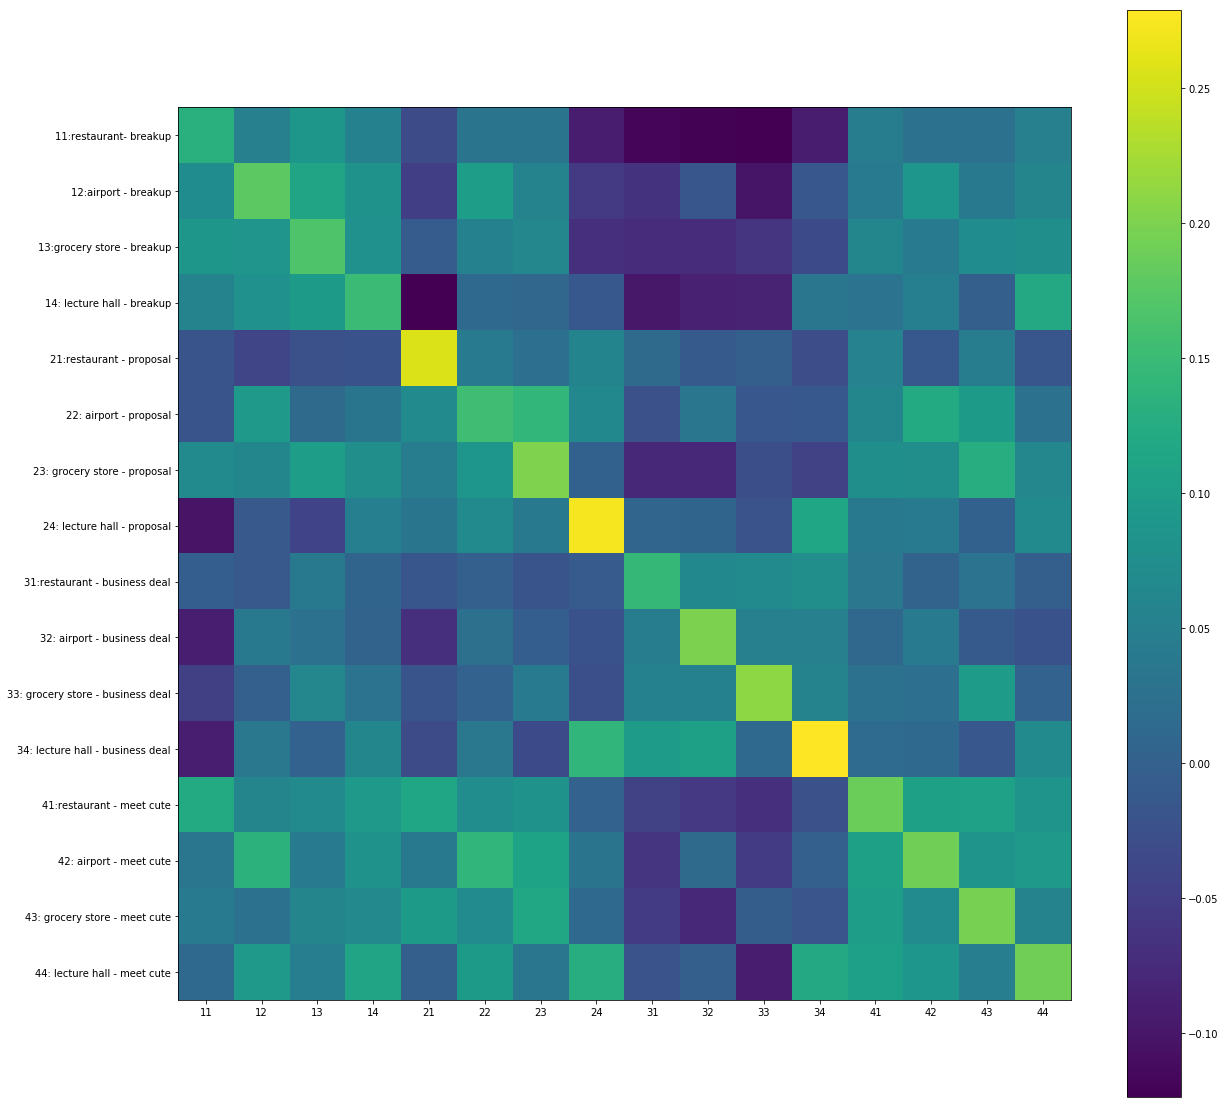

In [6]:
normed_matrix = normalize(correls, axis=0, norm='l1')

fig, ax = plt.subplots(1,1, figsize=(20,20))
im = ax.imshow(normed_matrix)

fig.colorbar(im)

# X ticks
ax.set_xticks(np.arange(0,16))
ax.set_xticklabels(story_order)

# Y ticks
ax.set_yticks(np.arange(0,16))
ax.set_yticklabels(y_label)


# II. Recall to grouped-stories comparison
## Create a 4 x 16 matrix, same story, same loc schema, same soc schema, no similarity

## A. Function to give the location schema and social schema with input of the story

In [8]:
def loc_soc(n): 
    loc = n%10
    soc = round(n/10) *10
    return loc, soc

## B. Creating the 4 x 16 matrix
### For each participant, get the correlation between it and each story, avg the storys within the same grouping (same loc) same soc, no same schema), so that you have a 4 X 1 matrix for each participant. For each story, avg across all participants

In [9]:
story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]
template_order = [1,2,3,4,10,20,30,40]
four_correls = np.zeros((4,16))
count = 0

for key in story_order:
    n = sums[key][0]
    # vector for each story with all participants
    all_partcs = np.zeros((4, n))
    # get the location and social schemas
    this_loc, this_soc = loc_soc(key)
    # Loop through all conditions
    count_inner = 0
    for i in range(0, 3):
        n_partc = recalls[key][i].shape[0]
        for j in range(0, n_partc):
            # Create a 4 x 1 vector for this participant
            these_4 = np.zeros((4,1))
            # Select the recall for this participant
            this_vec = recalls[key][i][j]
            #create the vectors to be filled matching 1 of 4 conditions
            same_loc = np.zeros((3,1))
            same_soc = np.zeros((3,1))
            not_same = np.zeros((9,1))
            # Create the counts for the vectors
            loc_count = 0
            soc_count = 0
            ns_count = 0
            for story_key in story_order:
                # If the key is the same as the story_key
                if story_key == key:
                    this_coef = np.corrcoef(this_vec, stories[story_key])
                    these_4[0] = this_coef[0,1]
                else:
                    story_loc, story_soc = loc_soc(story_key)
                    if story_loc == this_loc:
                        this_coef = np.corrcoef(this_vec, stories[story_key])
                        same_loc[loc_count] = this_coef[0,1]
                        loc_count += 1
                    elif story_soc == this_soc:
                        this_coef = np.corrcoef(this_vec, stories[story_key])
                        same_soc[soc_count] = this_coef[0,1]
                        soc_count += 1
                    else:
                        this_coef = np.corrcoef(this_vec, stories[story_key])
                        not_same[ns_count] = this_coef[0,1]
                        ns_count += 1
            # Avg the same loc schema correlations
            these_4[1]= np.mean(same_loc)
            # Avg the same soc schema correlations
            these_4[2]= np.mean(same_soc)
            # Avg the not same correlations
            these_4[3]= np.mean(not_same)
            these_4 = np.ravel(these_4)
            all_partcs[:, count_inner] = these_4
            count_inner += 1
    # Avg all_partcs
    this_avg = np.mean(all_partcs, axis = 1)
    four_correls[:, count] = this_avg
    count += 1

## C. Plot

[Text(0, 0, 'same story'),
 Text(0, 1, 'same loc schema'),
 Text(0, 2, 'same soc schema'),
 Text(0, 3, 'no shared schema')]

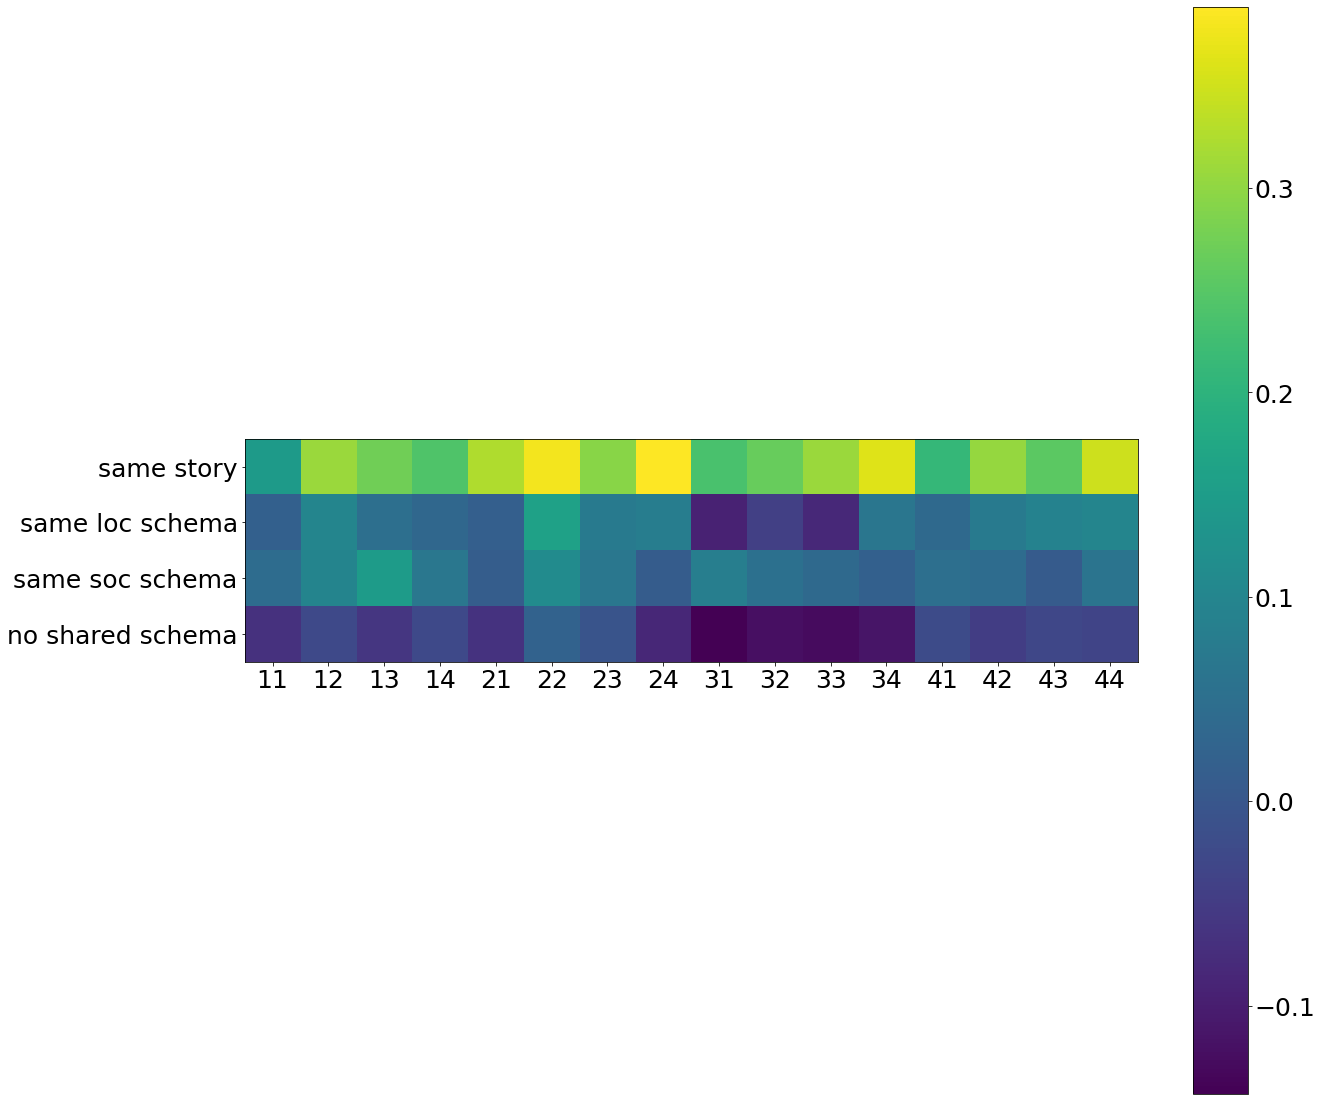

In [10]:
y_label = ['same story', 'same loc schema', 'same soc schema', 'no shared schema']

fig, ax = plt.subplots(1,1, figsize=(20,20))
im = ax.imshow(four_correls)

fig.colorbar(im)

# X ticks
ax.set_xticks(np.arange(0,16))
ax.set_xticklabels(story_order)

# Y ticks
ax.set_yticks(np.arange(0,4))
ax.set_yticklabels(y_label)



## D. Avg across all participants and plot

[Text(0, 0, 'same story'),
 Text(0, 1, 'same location script'),
 Text(0, 2, 'same social script'),
 Text(0, 3, 'no shared script')]

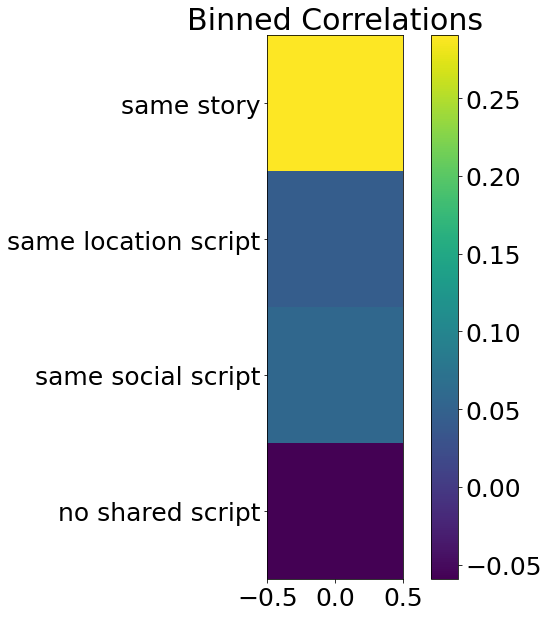

In [14]:
avg_four = np.mean(four_correls, axis = 1)
avg_four = np.reshape(avg_four, (-1, 1))

y_label = ['same story', 'same location script', 'same social script', 'no shared script']

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_four)

fig.colorbar(im)

plt.title('Binned Correlations')

# Y ticks
ax.set_yticks(np.arange(0,4))
ax.set_yticklabels(y_label)


In [37]:
avg_four.shape

(4,)